<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/22_03_27_GD_4_cutmix_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##라이브러리 임포트

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

##GPU 확인

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##데이터 불러오기

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split         = ["train", "test"],
    shuffle_files = True,
    with_info     = True
)

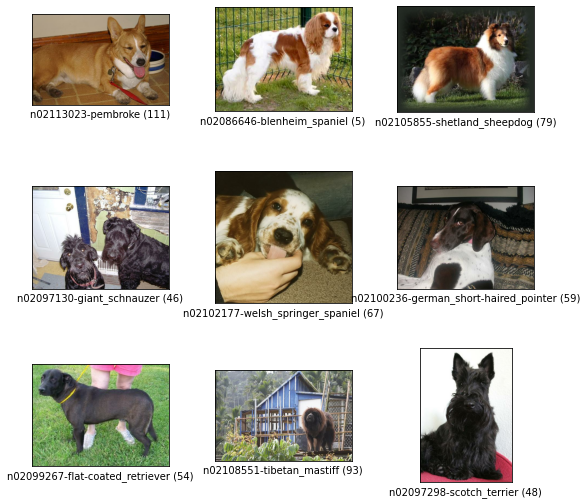

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)


##정규화 리사이즈 함수

In [ ]:
def normalize_and_resize_img(image, label):
  #uint8 > float32
  image = tf.image.resize(image,[224,224])
  return tf.cast(image, tf.float32) / 255., label

augment 함수

tf.image.random_crop(image, size=[180,180,3])

여기서 맨 뒤에 채널 수를 꼭 넣어야하는지 아닌지 모르겠다.

노드에서는 안 썼는데 연습할 때 안 쓰니까 에러가 났다.

In [ ]:
def augment(image, label):

  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_brightness(image, max_delta = 0.1)
  #image = tf.image.random_hue(image, max_delta = 0.2)
  image = tf.image.random_crop(image, size=[180,180,3])
  image = tf.image.resize(image,[224,224])
  image = tf.image.random_jpeg_quality(image, 75, 95)
  #image = tf.image.random_saturation(image, 5, 10)
  image = tf.clip_by_value(image, 0, 1)

  return image, label

normalize & augmentation 함수(훈련, 테스트 데이터일때 나눠서)

In [ ]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size=16, with_aug = False):
  ds = ds.map(normalize_and_resize_img, #기본적인 전처리함수 적용
              num_parallel_calls=2) # 이게 뭐지

  if not is_test and with_aug:
    ds = ds.map(
        augment,
        num_parallel_calls=2
    )

  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  
  return ds

##CUTMIX
바운딩 박스 만드는 함수

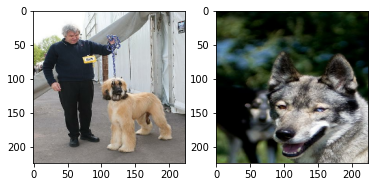

In [ ]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
#for i, (image, label) in enumerate(next(ds_train_no_aug.__iter__())):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
  image_size_x = image_a.shape[1] #가로, 세로와 shape 순서는 반대인가보다
  image_size_y = image_a.shape[0]

  #바운딩 박스 센터 찾기
  x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

  #박스의 가로, 세로 길이 정하기
  width = tf.cast(image_size_x*tf.math.sqrt(1-(tf.random.uniform([], 0, 1))), tf.int32)
  height = tf.cast(image_size_y*tf.math.sqrt(1-(tf.random.uniform([], 0, 1))), tf.int32)

  x_min = tf.math.maximum(0, x - width//2)
  y_min = tf.math.maximum(0, y - height//2)
  x_max = tf.math.minimum(image_size_x, x + width//2)
  y_max = tf.math.minimum(image_size_y, y + width//2) #height이 아니라..?
  #y_max = tf.math.minimum(image_size_y, y*height//2)

  return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x: ', x_min, x_max)
print('y: ', y_min, y_max)

x:  tf.Tensor(86, shape=(), dtype=int32) tf.Tensor(168, shape=(), dtype=int32)
y:  tf.Tensor(127, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바운딩 박스 기준으로 이미지 두개 합치는 함수

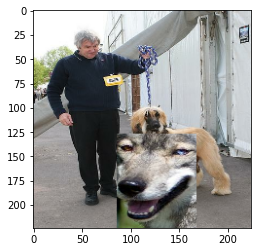

In [ ]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]

  middle_left = image_a[y_min:y_max, 0:x_min, :] #image_b의 왼쪽 바깥 영역
  middle_center = image_b[y_min:y_max, x_min:x_max, :] #image_b의 안쪽 영역
  middle_right = image_a[y_min:y_max, x_max:image_size_x, :] #image_b의 오른쪽 바깥영역

  middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
  top = image_a[0:y_min, :, :]
  bottom = image_a[y_max:image_size_y, :, :]

  mixed_img = tf.concat([top, middle, bottom], axis=0)

  return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

이미지 차지하는 비율만큼 적절한 비율의 라벨로 합쳐주는 함수

In [ ]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]
  mixed_area = (x_max-x_min)*(y_max-y_min)
  total_area = image_size_x * image_size_y
  ratio = tf.cast(mixed_area / total_area, tf.float32)

  if len(label_a.shape) == 0:
    label_a = tf.one_hot(label_a, num_classes)
  if len(label_b.shape) == 0:
    label_b = tf.one_hot(label_b, num_classes)

  mixed_label = (1-ratio) * label_a + ratio * label_b
  return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.841478  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

최종 CutMix 함수

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
  mixed_imgs = []
  mixed_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]
    j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
    image_b = image[j]
    label_b = label[j]

    x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
    mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max,y_max))
    mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

  mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
  mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
  return mixed_imgs, mixed_labels

##Mixup

두개를 적절한 투명도로 겹쳐주는 함수

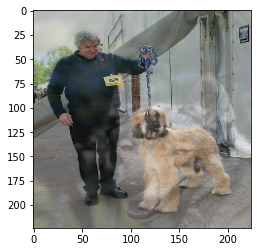

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.7116153  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.28838468 0.         0.         

In [ ]:
#num_classes = ds_info.features['label'].num_classes
num_classes = 120

def mixup_2_images(image_a, image_b, label_a, label_b):
  ratio = tf.random.uniform([], 0, 1)

  if len(label_a.shape) == 0:
    label_a = tf.one_hot(label_a, num_classes)
  if len(label_b.shape) == 0:
    label_b = tf.one_hot(label_b, num_classes)
  mixed_image = (1-ratio)*image_a + ratio*image_b # 1 이하의 수를 곱하면 그냥 투명도가 적용되는구나..
  mixed_label = (1-ratio)*label_a + ratio*label_b

  return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

최종 Mixup 함수

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
  mixed_imgs = []
  mixed_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]
    #j = tf.cast(tf.random.uniform([],0,batch_size), tf.float32)
    j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
    image_b = image[j]
    label_b = label[j]

    mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
    mixed_imgs.append(mixed_img)
    mixed_labels.append(mixed_label)

  mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
  mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
  return mixed_imgs, mixed_labels

one-hot 함수

In [ ]:
def onehot(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    imgs   = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    
    return onehot_imgs, labels

CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()(중요!!!!!!)

이걸 안 넣어줘서 엄청 고생했다ㅜㅜ

In [ ]:
'''
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label'''

'\ndef normalize_and_resize_img(image, label):\n    """Normalizes images: `uint8` -> `float32`."""\n    image = tf.image.resize(image, [224, 224])\n    return tf.cast(image, tf.float32) / 255., label\n\ndef augment(image,label):\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_brightness(image, max_delta=0.2)\n    return image,label'

위에 모든 과정을 구현한 메인 함수

단, shuffle, augmentation은 ds_test에는 적용시키면 안됨



In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix= False, with_mixup = False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )
  if not is_test and with_aug:
    ds = ds.map(augment)

  ds = ds.batch(batch_size) # CutMix는 배치 안에 있는 이미지들끼만 섞는 과정이므로 배치화 되어있어야 한다

  if not is_test and with_cutmix:
    ds = ds.map(cutmix, num_parallel_calls=2)

  elif not is_test and with_mixup:
    ds = ds.map(mixup, num_parallel_calls=2)

  else:
    ds = ds.map(onehot, num_parallel_calls=2)

  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

##학습
데이터 로드

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

전처리 적용하기

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) #no_aug
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) #with_aug
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True) #cutmix
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True) #mixup

ds_test = apply_normalize_on_dataset(ds_test, is_test = True) #shuffle과 augment 뺀 것

전처리가 잘 들어갔는지 확인

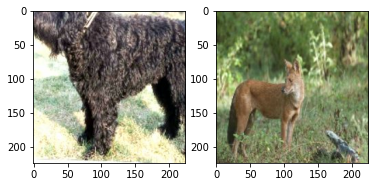

In [ ]:
for i, (image, label) in enumerate(ds_train_aug.take(1)):
#for i, (image, label) in enumerate(next(ds_train_no_aug.__iter__())):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

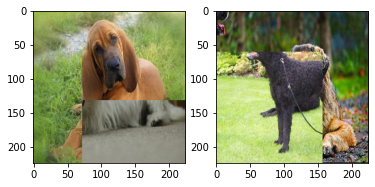

In [ ]:
for i, (image, label) in enumerate(ds_train_cutmix.take(1)):
#for i, (image, label) in enumerate(next(ds_train_no_aug.__iter__())):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

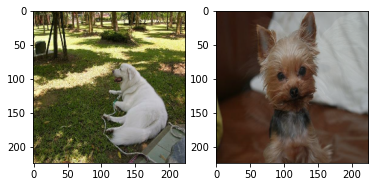

In [ ]:
for i, (image, label) in enumerate(ds_train_mixup.take(1)):
#for i, (image, label) in enumerate(next(ds_train_no_aug.__iter__())):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)
plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

##모델 구성하기
no aug model

In [ ]:
num_classes = ds_info.features['label'].num_classes
resnet50 = keras.models.Sequential([
                                  keras.applications.resnet.ResNet50(
                                      include_top = False, #맨 마지막 fully connected 레이어를 포함할지 여부
                                      weights = 'imagenet',
                                      input_shape = (224,224,3),
                                      pooling='avg'
                                  ), keras.layers.Dense(num_classes, activation='softmax')
])

aug model

In [ ]:
#with aug
aug_resnet50 = keras.models.Sequential([
                                  keras.applications.resnet.ResNet50(
                                      include_top = False,
                                      weights = 'imagenet',
                                      input_shape = (224,224,3),
                                      pooling='avg',
                                  ), keras.layers.Dense(num_classes, activation='softmax')])

#with cutmix
cutmix_resnet50 = keras.models.Sequential([
                                  keras.applications.resnet.ResNet50(
                                      include_top = False,
                                      weights = 'imagenet',
                                      input_shape = (224,224,3),
                                      pooling='avg',
                                  ), keras.layers.Dense(num_classes, activation='softmax')])

#with mixup
mixup_resnet50 = keras.models.Sequential([
                                  keras.applications.resnet.ResNet50(
                                      include_top = False,
                                      weights = 'imagenet',
                                      input_shape = (224,224,3),
                                      pooling='avg',
                                  ), keras.layers.Dense(num_classes, activation='softmax')])

In [ ]:
cutmix_resnet50.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


###학습

+ categorical_crossentropy ; 다중 분류 손실함수. one-hot encoding 클래스

+ sparse_categorical_crossentropy ; 다중 분류 손실함수. 위와 동일하지만 , integer type 클래스라는 것이 다르다.(one-hot 필요 없음)


In [ ]:
EPOCH = 10

resnet50.compile(
    loss = 'categorical_crossentropy', # 왜 sparse는 안되지? > one hot을 해서!
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), #뭐여? 750
    validation_steps = int(ds_info.splits['test'].num_examples/16), #위에서 배치 사이즈는 16이었다
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 117s 137ms/step - loss: 0.5348 - accuracy: 0.8644 - val_loss: 1.3671 - val_accuracy: 0.6098
Epoch 2/10
750/750 [==============================] - 118s 157ms/step - loss: 0.1922 - accuracy: 0.9662 - val_loss: 0.9702 - val_accuracy: 0.7107
Epoch 3/10
750/750 [==============================] - 99s 132ms/step - loss: 0.0977 - accuracy: 0.9888 - val_loss: 0.9806 - val_accuracy: 0.7235
Epoch 4/10
750/750 [==============================] - 118s 157ms/step - loss: 0.0421 - accuracy: 0.9977 - val_loss: 0.9532 - val_accuracy: 0.7299
Epoch 5/10
750/750 [==============================] - 99s 131ms/step - loss: 0.0225 - accuracy: 0.9992 - val_loss: 0.9544 - val_accuracy: 0.7357
Epoch 6/10
750/750 [==============================] - 118s 158ms/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.9559 - val_accuracy: 0.7388
Epoch 7/10
750/750 [==============================] - 99s 132ms/step - loss: 0.0087 - accuracy: 0.9998 - val_loss: 0.9718 - val_accuracy:

In [ ]:

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 173s 136ms/step - loss: 2.3114 - accuracy: 0.4235 - val_loss: 3.2337 - val_accuracy: 0.2239
Epoch 2/10
750/750 [==============================] - 100s 134ms/step - loss: 1.0547 - accuracy: 0.6891 - val_loss: 1.2101 - val_accuracy: 0.6551
Epoch 3/10
750/750 [==============================] - 120s 160ms/step - loss: 0.7133 - accuracy: 0.7923 - val_loss: 1.3243 - val_accuracy: 0.6363
Epoch 4/10
750/750 [==============================] - 101s 134ms/step - loss: 0.4697 - accuracy: 0.8706 - val_loss: 1.3682 - val_accuracy: 0.6334
Epoch 5/10
750/750 [==============================] - 120s 160ms/step - loss: 0.3046 - accuracy: 0.9235 - val_loss: 1.3871 - val_accuracy: 0.6437
Epoch 6/10
750/750 [==============================] - 120s 160ms/step - loss: 0.2006 - accuracy: 0.9533 - val_loss: 1.4494 - val_accuracy: 0.6291
Epoch 7/10
750/750 [==============================] - 100s 134ms/step - loss: 0.1364 - accuracy: 0.9716 - val_loss: 1.5986 - val_accura

In [ ]:

cutmix_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
750/750 [==============================] - 113s 135ms/step - loss: 3.8288 - accuracy: 0.2112 - val_loss: 3.4006 - val_accuracy: 0.2058
Epoch 2/10
750/750 [==============================] - 100s 134ms/step - loss: 2.9467 - accuracy: 0.4322 - val_loss: 1.6847 - val_accuracy: 0.5448
Epoch 3/10
750/750 [==============================] - 119s 159ms/step - loss: 2.6539 - accuracy: 0.5315 - val_loss: 1.3773 - val_accuracy: 0.6237
Epoch 4/10
750/750 [==============================] - 119s 159ms/step - loss: 2.4452 - accuracy: 0.5963 - val_loss: 1.5219 - val_accuracy: 0.5953
Epoch 5/10
750/750 [==============================] - 119s 159ms/step - loss: 2.3007 - accuracy: 0.6407 - val_loss: 1.3332 - val_accuracy: 0.6448
Epoch 6/10
750/750 [==============================] - 100s 134ms/step - loss: 2.1848 - accuracy: 0.6755 - val_loss: 1.2317 - val_accuracy: 0.6627
Epoch 7/10
750/750 [==============================] - 100s 133ms/step - loss: 2.0908 - accuracy: 0.7052 - val_loss: 1.2010 -

In [ ]:

mixup_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 131s 160ms/step - loss: 3.7231 - accuracy: 0.2338 - val_loss: 3.6214 - val_accuracy: 0.1760
Epoch 2/10
750/750 [==============================] - 119s 158ms/step - loss: 2.8501 - accuracy: 0.4798 - val_loss: 1.6315 - val_accuracy: 0.5524
Epoch 3/10
750/750 [==============================] - 100s 134ms/step - loss: 2.5629 - accuracy: 0.5803 - val_loss: 1.4285 - val_accuracy: 0.6142
Epoch 4/10
750/750 [==============================] - 100s 133ms/step - loss: 2.4063 - accuracy: 0.6518 - val_loss: 1.2531 - val_accuracy: 0.6524
Epoch 5/10
750/750 [==============================] - 119s 158ms/step - loss: 2.2663 - accuracy: 0.6985 - val_loss: 1.3390 - val_accuracy: 0.6333
Epoch 6/10
750/750 [==============================] - 99s 132ms/step - loss: 2.1509 - accuracy: 0.7445 - val_loss: 1.2580 - val_accuracy: 0.6609
Epoch 7/10
750/750 [==============================] - 99s 132ms/step - loss: 2.0836 - accuracy: 0.7678 - val_loss: 1.1756 - val_accuracy

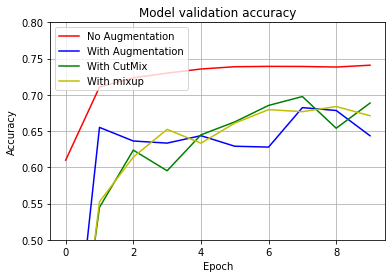

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정
plt.show()

###10 epochs 추가

In [ ]:
!mkdir -p /content/drive/MyDrive/aiffel/cutmix_checkpoint

In [ ]:
resnet50.save('/content/drive/MyDrive/aiffel/cutmix_checkpoint/resnet50.h5')
aug_resnet50.save('/content/drive/MyDrive/aiffel/cutmix_checkpoint/aug_resnet50.h5')
cutmix_resnet50.save('/content/drive/MyDrive/aiffel/cutmix_checkpoint/cutmix_resnet50.h5')
mixup_resnet50.save('/content/drive/MyDrive/aiffel/cutmix_checkpoint/mixup_resnet50.h5')

In [ ]:
resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/aiffel/cutmix_checkpoint/resnet50.h5')
aug_resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/aiffel/cutmix_checkpoint/aug_resnet50.h5')
cutmix_resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/aiffel/cutmix_checkpoint/cutmix_resnet50.h5')
mixup_resnet50 = tf.keras.models.load_model('/content/drive/MyDrive/aiffel/cutmix_checkpoint/mixup_resnet50.h5')

In [ ]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), #뭐여? 750
    validation_steps = int(ds_info.splits['test'].num_examples/16), #위에서 배치 사이즈는 16이었다
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
750/750 [==============================] - 112s 137ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.9875 - val_accuracy: 0.7402
Epoch 2/10
750/750 [==============================] - 101s 134ms/step - loss: 0.0059 - accuracy: 0.9999 - val_loss: 1.0003 - val_accuracy: 0.7407
Epoch 3/10
750/750 [==============================] - 101s 134ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 1.0011 - val_accuracy: 0.7368
Epoch 4/10
750/750 [==============================] - 119s 159ms/step - loss: 0.0050 - accuracy: 0.9998 - val_loss: 1.0089 - val_accuracy: 0.7375
Epoch 5/10
750/750 [==============================] - 101s 134ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.0159 - val_accuracy: 0.7387
Epoch 6/10
750/750 [==============================] - 119s 159ms/step - loss: 0.0052 - accuracy: 0.9998 - val_loss: 1.0242 - val_accuracy: 0.7400
Epoch 7/10
750/750 [==============================] - 119s 159ms/step - loss: 0.0084 - accuracy: 0.9994 - val_loss: 1.0350 -

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
750/750 [==============================] - 137s 163ms/step - loss: 0.0538 - accuracy: 0.9929 - val_loss: 1.2713 - val_accuracy: 0.6870
Epoch 2/10
750/750 [==============================] - 107s 143ms/step - loss: 0.0538 - accuracy: 0.9908 - val_loss: 1.3944 - val_accuracy: 0.6679
Epoch 3/10
750/750 [==============================] - 118s 158ms/step - loss: 0.0339 - accuracy: 0.9967 - val_loss: 1.3448 - val_accuracy: 0.6903
Epoch 4/10
750/750 [==============================] - 130s 173ms/step - loss: 0.0253 - accuracy: 0.9976 - val_loss: 1.3522 - val_accuracy: 0.6916
Epoch 5/10
750/750 [==============================] - 127s 170ms/step - loss: 0.0485 - accuracy: 0.9914 - val_loss: 1.4118 - val_accuracy: 0.6712
Epoch 6/10
750/750 [==============================] - 102s 136ms/step - loss: 0.0517 - accuracy: 0.9907 - val_loss: 1.2654 - val_accuracy: 0.6948
Epoch 7/10
750/750 [==============================] - 103s 137ms/step - loss: 0.0247 - accuracy: 0.9975 - val_loss: 1.3384 -

In [ ]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
750/750 [==============================] - 130s 160ms/step - loss: 1.8322 - accuracy: 0.7663 - val_loss: 1.2984 - val_accuracy: 0.6722
Epoch 2/10
750/750 [==============================] - 100s 133ms/step - loss: 1.8055 - accuracy: 0.7825 - val_loss: 1.2845 - val_accuracy: 0.6785
Epoch 3/10
750/750 [==============================] - 119s 159ms/step - loss: 1.7690 - accuracy: 0.7880 - val_loss: 1.3014 - val_accuracy: 0.6732
Epoch 4/10
750/750 [==============================] - 100s 134ms/step - loss: 1.7171 - accuracy: 0.7990 - val_loss: 1.4140 - val_accuracy: 0.6569
Epoch 5/10
750/750 [==============================] - 100s 134ms/step - loss: 1.6740 - accuracy: 0.8112 - val_loss: 1.3509 - val_accuracy: 0.6743
Epoch 6/10
750/750 [==============================] - 119s 159ms/step - loss: 1.6488 - accuracy: 0.8141 - val_loss: 1.4241 - val_accuracy: 0.6659
Epoch 7/10
750/750 [==============================] - 101s 134ms/step - loss: 1.6319 - accuracy: 0.8156 - val_loss: 1.5165 -

In [ ]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True
)

Epoch 1/10
750/750 [==============================] - 110s 135ms/step - loss: 1.8644 - accuracy: 0.8367 - val_loss: 1.1815 - val_accuracy: 0.6932
Epoch 2/10
750/750 [==============================] - 101s 135ms/step - loss: 1.8595 - accuracy: 0.8395 - val_loss: 1.2395 - val_accuracy: 0.6854
Epoch 3/10
750/750 [==============================] - 120s 160ms/step - loss: 1.8218 - accuracy: 0.8438 - val_loss: 1.2438 - val_accuracy: 0.6897
Epoch 4/10
750/750 [==============================] - 100s 134ms/step - loss: 1.7872 - accuracy: 0.8568 - val_loss: 1.4005 - val_accuracy: 0.6476
Epoch 5/10
750/750 [==============================] - 101s 134ms/step - loss: 1.7757 - accuracy: 0.8593 - val_loss: 1.2554 - val_accuracy: 0.6944
Epoch 6/10
750/750 [==============================] - 119s 159ms/step - loss: 1.7633 - accuracy: 0.8565 - val_loss: 1.2655 - val_accuracy: 0.6771
Epoch 7/10
750/750 [==============================] - 100s 134ms/step - loss: 1.7709 - accuracy: 0.8568 - val_loss: 1.3127 -

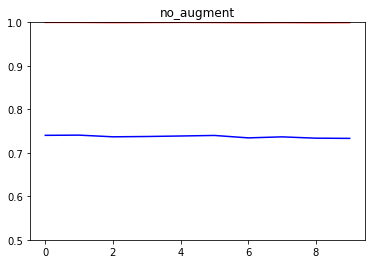

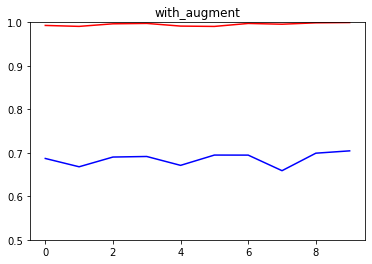

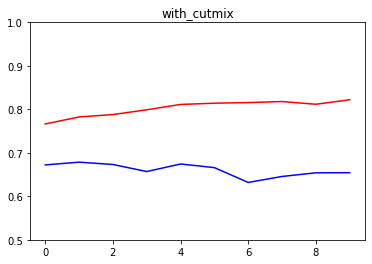

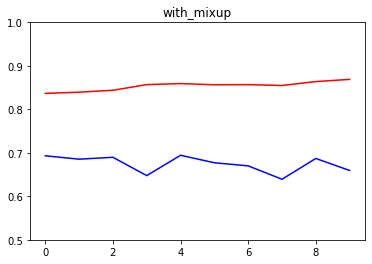

In [ ]:
#plt.subplot(2,2,1)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'b')
plt.title('no_augment')
plt.ylim(0.50, 1.0)
plt.show()


#plt.subplot(2,2,2)
plt.plot(history_resnet50_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('with_augment')
plt.ylim(0.50, 1.0)
plt.show()


#plt.subplot(2,2,3)
plt.plot(history_resnet50_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('with_cutmix')
plt.ylim(0.50, 1.0)
plt.show()

#plt.subplot(2,2,4)
plt.plot(history_resnet50_mixup.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('with_mixup')
plt.ylim(0.50, 1.0)
plt.show()

#plt.title('accuracy & validation accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['accuracy', 'val_accuracy', loc = 'upper left')
#plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정


확실히 과적합 방지에 효과가 있다

##회고

- 150 epochs 이상 돌려야 제대로 된 효과가 나타난다고 한다
- 좀 더 섬세한 augment의 필요성을 느꼈다
- one-hot 과 Tensor에 대한 이해가 아직 부족하다
- shuffle -> repeat -> batch vs repeat -> shuffle -> batch
